### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix


import matplotlib.pyplot as plt

from eolearn.core import  EOPatch
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation
from linder.other_util import download_data
import rasterio
import json
import cv2

from tqdm import tqdm
from tensorflow.keras.models import model_from_json
from pathlib import Path


from util import (reproject_labels,
                  crop_to_box,
                  get_labels_from_json,
                  resize_label_data_to_sentinel,
                  stack_all_data,
                  prepare_data_for_model
                 )

import pickle

/Users/hamidrezaomidvar/anaconda3/envs/main_env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
path_label=Path('./LC_data/Download_1515146/ukland_coloured_3541662')
before='tq.tif'
after='tq-wgs84.tif'
path_label_reprojected=reproject_labels(path_label,before,after)

In [3]:
coords_top = [51.338729, -0.605738]
coords_bot = [51.239767, -0.036034]
patch_n=6
s_date, e_date = "20160101", "20161231"
city_name='London'
path_save=city_name




path_EOPatch = download_data(path_save, coords_top, coords_bot, patch_n, s_date, e_date, debug=False)

In [11]:
data = EOPatch.load(path_EOPatch)
LC_data_path_masked=crop_to_box(path_label_reprojected,data.bbox.get_geometry())
label_data = get_labels_from_json(LC_data_path_masked)

In [ ]:
label_data_resized = resize_label_data_to_sentinel(path_EOPatch, image,label_data)
data_all,stacked_all=stack_all_data(path_EOPatch,label_data_resized,image)

In [ ]:
data = EOPatch.load(path_EOPatch)
image = 0
plt.imshow(data.data['BANDS'][image,:,:,:][...,[2,1,0]]*3.5,alpha=1)

plt.imshow(label_data_resized,alpha=1)

In [63]:
n_data=100
dataset,labelset,rgbset=prepare_data_for_model(stacked_all,n_data)

with open(f'data/data_{patch_n}.pickle', 'wb') as handle:
    pickle.dump([dataset,labelset,rgbset], handle)

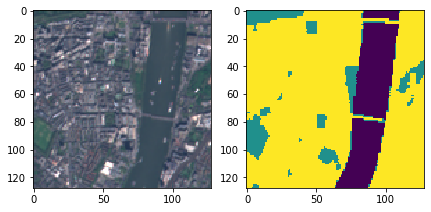

In [246]:
with open(f'data/data_{0}.pickle', 'rb') as handle:
    [dataset,labelset,rgbset] = pickle.load(handle)

fig,axes=plt.subplots(1,2,figsize=(7,7))

n=int(np.random.rand(1)*rgbset.shape[0])

ax=axes[0]
ax.imshow(np.clip(rgbset[n,:,:,:]*3.5,0,1))

ax=axes[1]
ax.imshow(labelset[n,:,:,0])

In [3]:
for patch_n in range(0,5):
    with open(f'data/data_{patch_n}.pickle', 'rb') as handle:

        [dataset_,labelset_,rgbset_] = pickle.load(handle)

        if patch_n == 0:
            [dataset,labelset,rgbset] =[dataset_,labelset_,rgbset_]
        else:
            dataset=tf.concat([dataset,dataset_],axis=0)
            labelset=tf.concat([labelset,labelset_],axis=0)
            rgbset=tf.concat([rgbset,rgbset_],axis=0)
    

# Model

In [4]:
OUTPUT_CHANNELS = 3

In [30]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [31]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [32]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  x = Activation('softmax')(x)  

  return tf.keras.Model(inputs=inputs, outputs=x)

In [33]:
def weighted_pixelwise_crossentropy(class_weights):
    
    def loss(y_true, y_pred):
        #epsilon = _to_tensor(_EPSILON, y_pred.dtype.base_dtype)
        y_pred = tf.clip_by_value(y_pred, 10e-8, 1. - 10e-8)
        return - tf.reduce_mean(tf.multiply(tf.cast(y_true,tf.float32) * tf.math.log(y_pred), class_weights))

    return loss




def soft_dice_loss(y_true, y_pred): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    epsilon=1e-6
    y_true=tf.cast(y_true,tf.float32)
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * tf.reduce_sum(y_pred * y_true, axes)
    denominator = tf.reduce_sum(tf.square(y_pred) + tf.square(y_true), axes)
    
    return 1-tf.reduce_mean(numerator / (denominator + epsilon)) # average over classes and batch


In [34]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              #loss=weighted_pixelwise_crossentropy([.4,.3,.3]),
              loss=soft_dice_loss,
              #loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[soft_dice_loss]
             )

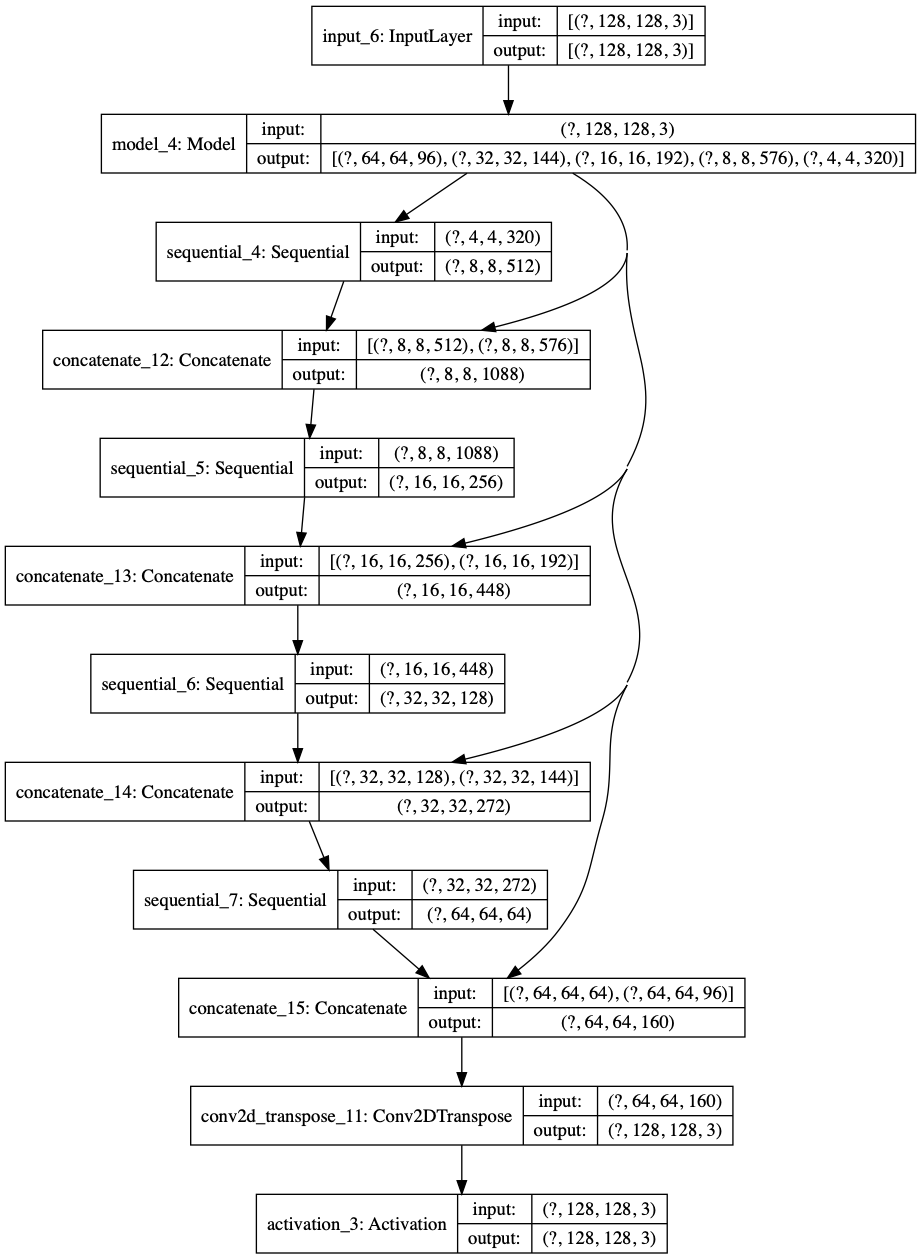

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
EPOCHS = 5
BATCH_SIZE = 64

labelset_one_hotted=tf.one_hot(tf.cast(labelset[:,:,:,0],tf.int32),depth=3,dtype=tf.int32)

model_history = model.fit(rgbset,labelset_one_hotted, 
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE)

Train on 500 samples
Epoch 1/5
500/500 [==============================] - 55s 110ms/sample - loss: 0.3742 - soft_dice_loss: 0.3752
Epoch 2/5
500/500 [==============================] - 45s 89ms/sample - loss: 0.3571 - soft_dice_loss: 0.3573
Epoch 3/5
500/500 [==============================] - 40s 79ms/sample - loss: 0.3388 - soft_dice_loss: 0.3386
Epoch 4/5
500/500 [==============================] - 40s 80ms/sample - loss: 0.3249 - soft_dice_loss: 0.3250
Epoch 5/5
500/500 [==============================] - 38s 75ms/sample - loss: 0.3135 - soft_dice_loss: 0.3138


In [55]:
model.evaluate(rgbset,labelset_one_hotted)

500/500 [==============================] - 17s 34ms/sample - loss: 0.8179 - soft_dice_loss: 0.8181


[0.817917236328125, 0.8181354]

In [38]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'RGB')

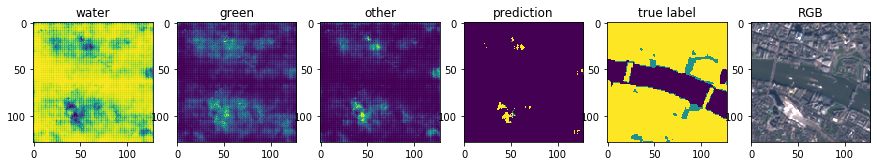

In [59]:
i=int(np.random.rand(1)*rgbset.shape[0])

x=rgbset[i:i+1,:,:,:]
y=labelset[i:i+1,:,:,:]
rgb=rgbset[i:i+1,:,:,:]*3.5

pred=model.predict(x)

fig,axes=plt.subplots(1,6,figsize=(15,15))


ax=axes[0]
ax.imshow(pred[0,:,:,0])
ax.set_title('water')

ax=axes[1]
ax.imshow(pred[0,:,:,1])
ax.set_title('green')


ax=axes[2]

ax.imshow(pred[0,:,:,2])
ax.set_title('other')

ax=axes[3]
ax.imshow(create_mask(pred)[:,:,0])
ax.set_title('prediction')


ax=axes[4]
ax.imshow(y[0,:,:,0])
ax.set_title('true label')

ax=axes[5]
ax.imshow(rgb[0,:,:])
ax.set_title('RGB')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'loh0')

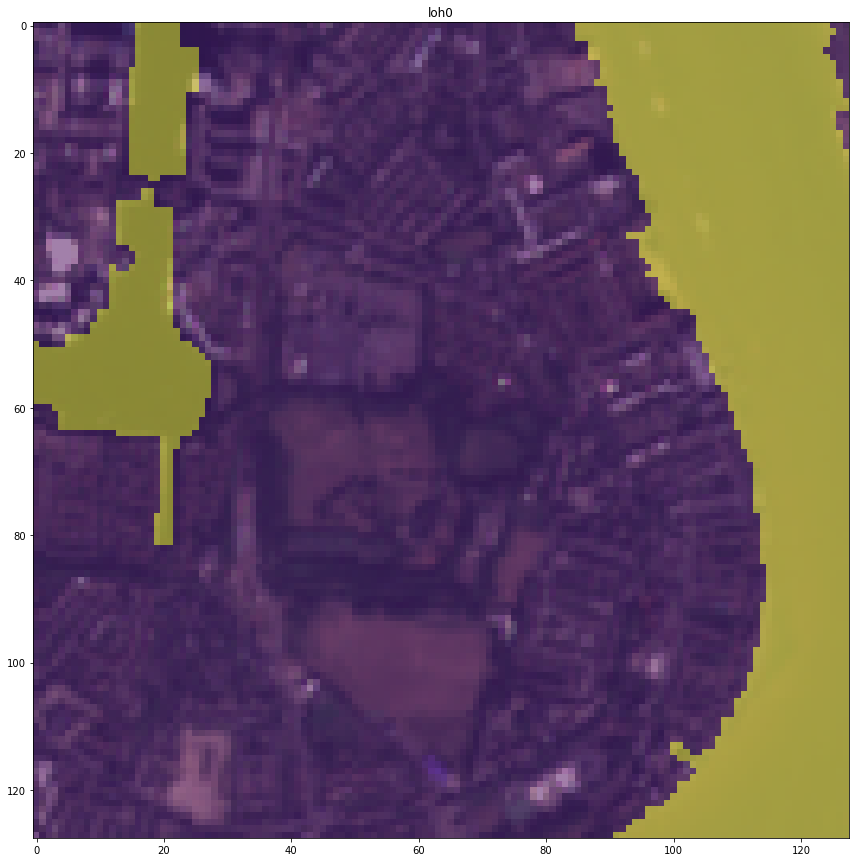

In [234]:
i=int(np.random.rand(1)*rgbset.shape[0])
fig,axes=plt.subplots(1,1,figsize=(15,15))
rgb=rgbset[i:i+1,:,:,:]*3.5
loh0=labelset_one_hotted[i:i+1,:,:,0]
loh1=labelset_one_hotted[i:i+1,:,:,1]
loh2=labelset_one_hotted[i:i+1,:,:,2]
ax=axes
ax.imshow(rgb[0,:,:])
ax.set_title('RGB')


ax=axes
ax.imshow(loh0[0,:,:],alpha=0.5)
ax.set_title('loh0')

# ax=axes[2]
# ax.imshow(loh1[0,:,:])
# ax.set_title('loh1')

# ax=axes[3]
# ax.imshow(loh2[0,:,:])
# ax.set_title('loh2')